<a href="https://colab.research.google.com/github/ZhiLi51/Final-Project-on-large-cap-crypto-trading-with-macroeconomical-variables/blob/main/time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Gathering Data
    
    
2. Data Exploration

    2.1. Plotting the Time-series
    

3. Finding Regressor Inputs

    3.1 Autocorrelation plot
    
    3.2. Creation of Dataset for training
    

4. Making a Neural Network


5. Splitting the data


6. Scaling the data


7. Training and Validation


8. Making Predictions on the test set

    8.1 Checking the r2 score
    
    8.2 Plotting the predictions

In [3]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [15]:
import yfinance as yf
df = yf.download('BTC-USD','2017-01-02','2022-05-10')

[*********************100%***********************]  1 of 1 completed


**2. Data Exploration**

Let's have a quick look first

In [16]:
import pandas as pd

In [17]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [18]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489
2022-05-07,36042.503906,36129.925781,34940.824219,35501.953125,35501.953125,24375896406
2022-05-08,35502.941406,35502.941406,33878.964844,34059.265625,34059.265625,36763041910
2022-05-09,34060.015625,34222.074219,30296.953125,30296.953125,30296.953125,63355494961
2022-05-10,30273.654297,32596.308594,29944.802734,31022.906250,31022.906250,59811038817


So, we have a datetime column, which is nice. 

Then the opening value at the start of every trading day, the closing values at whatever time traders must have call it a day, the highest and lowest values during each, and two other columns which I'm not so sure about, so I won't bother.

What we are interested in is just the closing value.

In [10]:
df_close = pd.DataFrame(df['Close'])

In [12]:
df_close.index = pd.to_datetime(df['Date'])

KeyError: ignored

It's better to have the DataFrame index in datetime format (pd.datetime) since it makes plotting, and slicing easier

In [19]:
df_close.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09',
               '2017-01-10', '2017-01-11',
               ...
               '2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04',
               '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08',
               '2022-05-09', '2022-05-10'],
              dtype='datetime64[ns]', name='Date', length=1955, freq=None)

In [20]:
df_close.head()

,Close
Date,
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005
2017-01-06,902.200989


In [21]:
df_close.describe()

,Close
count,1955.000000
mean,17199.649225
std,17614.143352
min,777.757019
25%,6112.099854
50%,9081.762695
75%,30924.302734
max,67566.828125


**2.1. Plotting the Time-series**

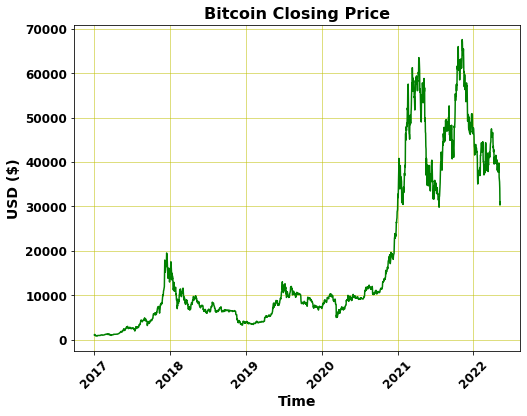

In [23]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df_close, color='g')
plt.title('Bitcoin Closing Price', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

**3. Finding Regressor Inputs**

There are many time-series forcasting techinques. First, there are the conventional statistical techniques like ARIMA, and exponential smoothing. Then there are other traditional approaches like Regression. Neural Networks have been popular in forecasting problems because of their ability to make predictions on non-linear complex data. Conventional statistical techniques don't work well with highly non-linear data. Multi-dimensional linear Regression has shown good results too on complex non-linear data (don't let the "linear" in it confuse you, it refers to the linear combination of input variables, the input variables themselves however can be expressed as higher degree polynomaials in the function that we are trying to model)

But we will do our predciting using a Neural Network. There are two basic paths to implement a model.

Some implement by considering the historical values of the very series they are trying to predict as the input regressors (variables). This approach assumes that the future values can be expressed as a fuction of the past values. The two things to determine are - which past values to use (how far back into the past we need to look), and the parameters of the function itself

Many times, we also include input variables that are of very different nature than the time-series under observation. For example, in Electrical load forecating the weather time series (temperature) is used as one of the input variables. It makes sense since in most regions of our planet, temperature does affect the electrical power consumption. A drop in the temperate regions would have people using more of their heaters, and in sub-tropical or tropical regions, a rise in temperatue typically drives the air-conditioning load.

Okay. So, first see how far into the past we need to look.

**3.1. Autocorrelation plot**

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


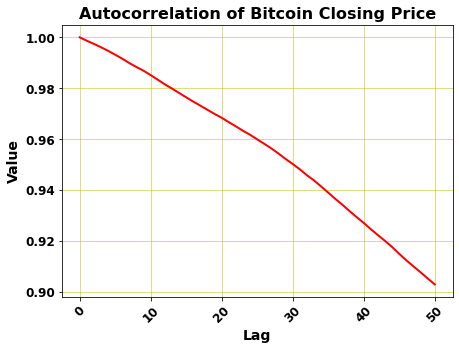

In [24]:
from statsmodels.tsa import stattools

acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(df_close,
                                                             unbiased=True,
                                                             nlags=50,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation of Bitcoin Closing Price', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

To see which past variables can be used as input in our model, we check the auto-correlation of the time-series. Most of you must be familiar with correlation. It's a way to measure the strength of association between any two variables. As the correlation value approaches 1, it indicates high postive association. Correlation near 0 indicates almost no association at all, and a values near -1 would indicate strong negative correlation.

In autocorrelation, we take the time-series value at current instant as one variable and one of the values from a time-instant in the past as the other variable, and find the correlation between them.

Here, I have used 'stattools.acf' (acf for autocorrelation fucntion) to plot the autocorrelation with 50 past time-instants (lags). It's from the 'statsmodels' library. It's a great tool for doing a wide range of statistical analysis. Don't worry if you don't get this particular fuction in the first look. All you need to know is that is this function returns four outputs, out of which the first one which I have assigned the name 'acf_djia' is the list containing autocorrelation values of the number of lags ('nlags') specified.

Choosing a lot of input attributes, specially if they don't have a high enough correlation with the target attribute, could actually harm us. I will select all the lags (past values) that have at least a correlation of 0.9 with the present value. From the plot we can see that number is 15.

TLDR : What this means is that we will use the closing price of past 15 days to predict the closing price of any particular day. 

So, if you have the closing prices of any particular stock up until today, you can use this model to predict the closing price tomorrow.

Well, you only need today's closing price and the closing price of past fourteen days to predict tomorrow's closing price.

We still do need all the hsitorical data that we have to train, and test out model.

**3.2. Creation of dataset for training**

Right now we only have one column - the actual closing price of Bitcoin (apart from the datetime index of course). To train our neural network, we have decided to use the past 15 values as inputs with the value at any corresponding time instant. This means we will have now an additional 15 columns where each row will have the closing price at any day and the corresponding prices of the past fifteen days.

I have created a function to create those columns. 

In [25]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [26]:
list_of_attributes = ['Close']

list_of_prev_t_instants = []
for i in range(1,16):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Here, we only have one time-series that is the closing price everyday. Using the function that I've defined, we can create regressor attributes for muliple columns in a single dataframe. For example, say we want to model current electrical load using not only past load values but also past temperature values.

Also, we can specify which past values to use exaclty in the form of a list. It's heplful in cases where the past regressors can be different than simply the previous fifteen values. In our case it is so because the auto-correlation line was an almost straight line with a negative line.

In [27]:
df_new = create_regressor_attributes(df_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5),Close_(t-6),Close_(t-7),Close_(t-8),Close_(t-9),Close_(t-10),Close_(t-11),Close_(t-12),Close_(t-13),Close_(t-14),Close_(t-15)
datetime,,,,,,,,,,,,,,,,
2017-01-17,907.937988,831.533997,821.797974,818.411987,823.984009,804.833984,777.757019,907.679016,902.828003,911.198975,908.585022,902.200989,1013.380005,1154.729980,1043.839966,1021.750000
2017-01-18,886.617981,907.937988,831.533997,821.797974,818.411987,823.984009,804.833984,777.757019,907.679016,902.828003,911.198975,908.585022,902.200989,1013.380005,1154.729980,1043.839966
2017-01-19,899.072998,886.617981,907.937988,831.533997,821.797974,818.411987,823.984009,804.833984,777.757019,907.679016,902.828003,911.198975,908.585022,902.200989,1013.380005,1154.729980
2017-01-20,895.026001,899.072998,886.617981,907.937988,831.533997,821.797974,818.411987,823.984009,804.833984,777.757019,907.679016,902.828003,911.198975,908.585022,902.200989,1013.380005
2017-01-21,921.789001,895.026001,899.072998,886.617981,907.937988,831.533997,821.797974,818.411987,823.984009,804.833984,777.757019,907.679016,902.828003,911.198975,908.585022,902.200989


In [28]:
df_new.shape

(1940, 16)

Okay, phew..

We have out dataset. Let's now build our neural network.

**4. Making the neural Network**

I will be training a simple Multi-layer Perceptron that has an input layer with 15 nodes (accounting for each of the 15 past regressor inputs).

It will have 2 hidden layers (yeah, 2 and that's what makes it "DEEP", nothing more, nothing less). I'll consider 60 nodes in each.

Why 60? I tried a lot of trials and combinations, and I was satisfied with the results of this one. 

And hyperparameter tuning (adjusting the model parameters to find the optimal combination) won't be a part of this exercise. 


In [29]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
input_layer = Input(shape=(15), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [31]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 60)                960       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


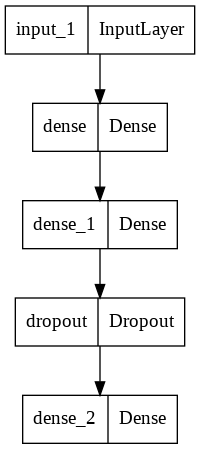

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Those familiar with Neural networks and Keras can skip this part. 

Those very new to Machine Learning can have a glance to absorb enough to move forward. 

An input layer only has nodes. It's only job is take in the data and pass it on the hidden layer.

A dense layer has the links (edges) connected to it, with weights and everything. It also has an activation function.

The data from each input node gets multiplied with the weights of the links via which those input nodes are connected to the first hidden layer. Each node of the hidden layer then combines all the inputs to it (one from each input node) and passes through an activation fuction.

Similar process repeats for the second hidden layer.

A dropout layer is added before the output layer. It drops a certain percentage (20% in our case) of the links randomly, that are connected to the output node. It's a good practice and generally helps in curbing overfitting.

We simply define each layer and the preceding layer it's connected to, and then package them all together using the function 'Model'

The 15 new columns dataframe (df_new) will be passed through this network, one row at a time. The network will spit out an answer which will be compared with the value in the first column. This first prediction will be based on weights that mare set randomly. The error in the prediction will be used to change the weights in such a way that the prediction is better.

This will happen for all the 1034 rows. We can adjust the weights after passing through multiple samples (rows) in what we call a "batch". When all the rows have passed in this way, we say one "epoch" is over. We go through many epochs.

But how many epochs do we have to go through, you ask? You already might have guessed. When we get the feel that out neural network model has captured the patterns in the data and is in a position to make predictions. How do we ensure that?

What we do is hold out a few samples of data as a validation set. We don't use them for training (i.e for updating the weights). We only run the validation set after every epoch, and check the error. We also keep a track of the training error but it's not as important as validation error since the training error is what adjusts the weights. So, in a sense the training data is what the network soaks in. The validation data is something it doesn't soak in. As we keep checking the errors, only when the validation error has come down to near the training error, we stop further training.

There are many ways to calcualte error. Here, we have used "mean_squared_error", and also used the "adam" optimizer algorith that is responsible for updating the weights (see "model.compile" part).

We can also hold out an additional test set just to see how out new baby performs on more unseen data.

**5. Spliting the data**

We will separate out 5% of the samples (rows) in a random fashion for later testing purposes. 

The remaining 95 % is again split randomly. Some 5% of it is used as validation set and the remaining as training set.

All this splitting happens row wise.

Note that we also need to split it column wise as well. The first column are our actual values (target). These aren't fed to the neural network. The remaining 15 columns (input regressors) are fed to it.

So, the slicing of data happens both row wise and column wise. The sliced dataframes having only the regressor input columns typically have a "X" in the names we assign them, and the sliced dataframes (or series) with only the actual values (also called target values, as in being "targets" for the neural netwroks to accurately predict while training) have a "y" in the names we assign them.

Note that since this is time-series data, splitting the dataset randomly isn't a sensible thought. So, for time-series data, we will simply split in an orderly fashion.

In [34]:
import numpy as np

In [35]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (1750, 15) (1750,)
Shape of validation inputs, validation target: (93, 15) (93,)
Shape of test inputs, test target: (97, 15) (97,)


**6. Scaling the data**

We will normalize our data in the range in the range (0.01, 0.99) before feeding it to the the neural network.

Note that MinMaxScaler() function takes in dataframes or series (can also take in arrays), but it always returns n-dimensional arrays.

In [36]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

So, the data is ready. The neural network is ready. Let's go.

**7. Training and Validation**

In [37]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/30
350/350 [==============================] - 3s 4ms/step - loss: 0.0123 - val_loss: 0.0092
Epoch 2/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 3/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0072
Epoch 4/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0127
Epoch 5/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 6/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 7/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 8/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 9/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 10/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0059

In case the validation loss had remained significantly more than the training loss at the end of training, but was continously coming down in the last few epochs, it would have been an indication that we need to run our model for more epochs, as the model needed more training.

If the validation loss had remained significantly more than the training loss at the end of training, and also become more or less static, then it would have been an indication of "overfitting", that is our model works far too well on the training data, it has perfectly captured it, including the noise, but it would work poorly on unseen data. In such a case, it's advised to increase the value in the dropout layer, reduce number of epcohs, increase the batch size, reduce the number of hidden layers, reduce the number of nodes in the hidden layers.

Our Validation loss doesn't seem to have changed much, specially when compared to the training loss. We can attribute that to the small number of training examples that we have, in the context of the model that we have used.

LSTMs and CNNs may be able to give better results than a conventional NN on the same data. That's for another time. We only want to get our first hands on experience for now.

**8. Making predictions on the test set**

In [38]:
y_pred = model.predict(X_test_scaled)

Recall that all our inputs and targets were scaled down in the range (0, 1). So, the predictions also lie in that range. We need to scale them back in the other direction

In [39]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

**8.1. Checking the r2 score **

One of the ways to measure the performance of our model on the test data is to compare the error of its predictions with respect to the true values. That could be mean squared error, or mean average error etc.

We could also use use something called as r_squared (or r2) score. Just remember that like Regression, it measures the squared mean distance between true values and values lying the predictor hyperplane (our predicted values), and spits out a score between 0 and 1. More the r2 score closer to one, better the predictions of your model

In [40]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.6774


**8.2 Plotting the predictions **

We can add the datatime index so that it automatically takes care of the x-axis tick labels.

In [41]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Close Price'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Close Price'])

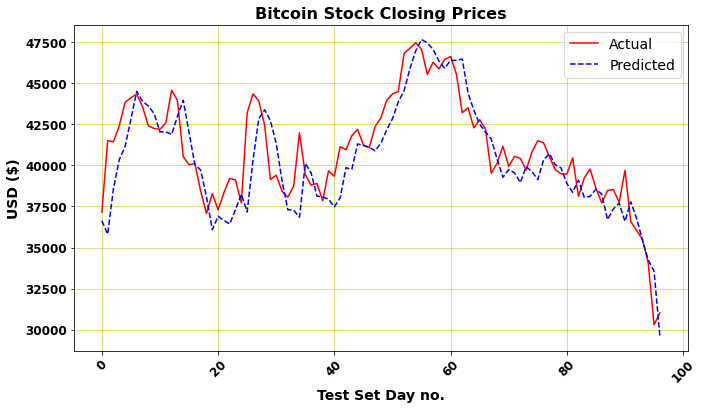

In [42]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Bitcoin Stock Closing Prices', weight='bold', fontsize=16)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

the predictions are pretty reliable, at least for a forecasting horizon of one day.
